In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, Embedding, Add, TimeDistributed, MultiHeadAttention, Layer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout2D, RepeatVector
import keras.backend as K
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras import metrics
import gzip
import pandas as pd
import pickle
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# data loading
with gzip.open('../data/segment_with_noise/ll_seg_500_noise.pkl.gzip', 'rb') as f:
    ll_seg_gps_noise = pickle.load(f)
with gzip.open('../data/segment_with_noise/rl_seg_500_noise.pkl.gzip', 'rb') as f:
    rl_seg_gps_noise = pickle.load(f)

with gzip.open('../data/segment_groud_truth/rl_seg_gt_500.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open('../data/segment_groud_truth/ll_seg_gt_500.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_gps_noise))
print(ll_seg_gps_noise[0].shape[0])
ll_seg_gps_noise[0].head()

500
77


,y,x,y_norm,x_norm,Vy_norm,Vx_norm,theta_norm,psi_norm,phi_norm,omega_Xv_norm,omega_Yv_norm,alpha_Xv_norm,alpha_Yv_norm,y_norm_noise,x_norm_noise
43567,42.246179,-83.563086,0.786530,0.206384,0.764706,0.778120,0.659098,0.423909,0.453957,0.466896,0.411583,0.508045,0.593818,0.795350,0.203490
43617,42.246167,-83.563112,0.785304,0.204631,0.764706,0.771957,0.658926,0.425454,0.448492,0.418745,0.388417,0.478467,0.536334,0.787305,0.203073
43667,42.246155,-83.563137,0.784089,0.202890,0.764706,0.764253,0.658731,0.431827,0.465695,0.474635,0.473359,0.473024,0.564262,0.788982,0.203170
43717,42.246143,-83.563163,0.782877,0.201164,0.764706,0.758089,0.658551,0.429316,0.485732,0.501290,0.439382,0.472314,0.590835,0.794082,0.195338
43767,42.246131,-83.563188,0.781676,0.199454,0.705882,0.753467,0.658312,0.419467,0.495041,0.423044,0.462548,0.519404,0.539588,0.791014,0.203958


In [3]:
x_ll = [] # sampled noisy GPS, list of lists of tuples
y_gps_ll = [] # sampled noisy GPS, list of lists of tuples
y_ll = [] # unsampled groud truth GPS, list of lists of tuples

for df in ll_seg_gps_noise:
    x_ll.append(df[['y_norm_noise', 'x_norm_noise', 'theta_norm', 'Vx_norm', 'Vy_norm']].values)
    y_gps_ll.append(df[['y_norm', 'x_norm']].values)

for df in ll_seg_gps_gt:
    y_ll.append(df[['y_norm', 'x_norm']].values)

In [4]:
# selecting max_y_len and max_x_len
max_x_len = max([len(x_seg) for x_seg in x_ll])
max_y_len = max([len(y_seg) for y_seg in y_ll])

max_x_len, max_y_len

(77, 3822)

In [5]:
embedding_dim = 128
latent_dim = 300

In [79]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1,), 
                               initializer='normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[-2],1,), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)  
        #e = keras.layers.Flatten()(e)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        #alpha = K.expand_dims(alpha, axis=-1)
        print(alpha.shape)
        temp = RepeatVector(embedding_dim)(alpha)
        
        temp = keras.layers.Permute([2, 1])(temp)
        temp = K.expand_dims(temp,axis=1)
        # multiply weight with lstm layer o/p
        output = x * temp
        #output = keras.layers.Multiply()([x, temp])
        output = K.sum(output, axis=1)
        # Get the attention adjusted output state
        #output = keras.layers.Lambda(lambda values: K.sum(values, axis=1))(output)
        # Pass output to step 4 and 'a' to any nice display
        # Compute the context vector
       # context = x * alpha
       # context = K.sum(context, axis=1)
        return output

(None, 77)
Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 77, 5)]      0           []                               
                                                                                                  
 dense1 (Dense)                 (None, 77, 512)      3072        ['Input[0][0]']                  
                                                                                                  
 dense2 (Dense)                 (None, 77, 128)      65664       ['dense1[0][0]']                 
                                                                                                  
 encoder1 (LSTM)                [(None, 77, 128),    131584      ['dense2[0][0]']                 
                                 (None, 128),                                   

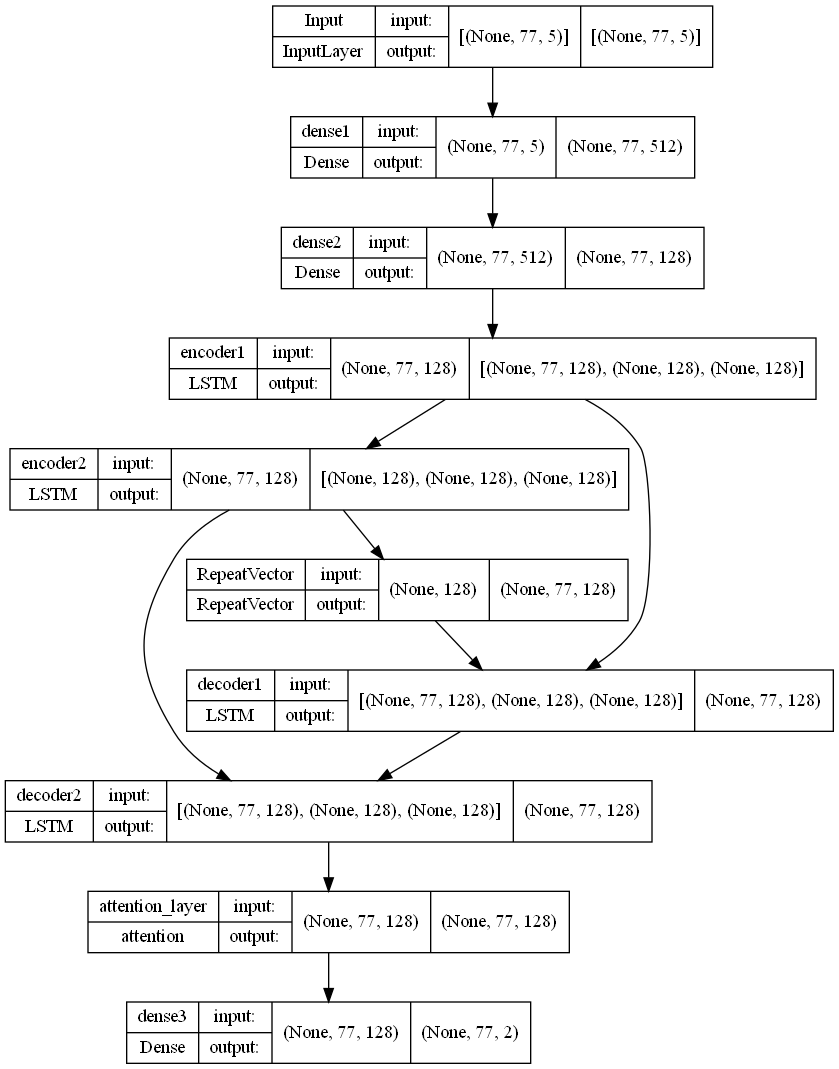

In [103]:
def create_LSTM(latent_dim, dense_units, return_sequences, input_shape):
    # dense layer of spatial embedding
    x_train_input = Input(shape=(input_shape), name='Input')
    x_spatial_embedd1 = Dense(256, name='dense1')
    x_spatial_embedd2 = Dense(embedding_dim, name='dense2')

    # x_train_temp_input = Input(shape=(77,))
    # temporal embedding
    # x_temporal_embedd = Embedding(max_x_len+1, embedding_dim, input_length=max_x_len+1, trainable=True) 

    # combining two features to get spatio-temporal feature representation of input trajectory
    # x_h_st = Add()([x_spatial_embedd2(x_spatial_embedd1(x_train_input)), x_temporal_embedd(x_train_temp_input)])
    x_h_st = x_spatial_embedd2(x_spatial_embedd1(x_train_input))


    encoder_l1 = LSTM(embedding_dim,return_sequences = True, return_state=True, dropout=0.1, name='encoder1')
    encoder_outputs1 = encoder_l1(x_h_st)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = LSTM(embedding_dim, return_state=True, name='encoder2')
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    #print(encoder_outputs2[0].shape)
    decoder_inputs = RepeatVector(77, name='RepeatVector')(encoder_outputs2[0])
    #decoder_layer = keras.layers[-1]
    decoder_l1 = LSTM(embedding_dim, return_sequences=True, name='decoder1')(decoder_inputs, initial_state = encoder_states1)
    decoder_l2 = LSTM(embedding_dim, return_sequences=True, name='decoder2')(decoder_l1, initial_state = encoder_states2)
    attention_layer = attention(name='attention_layer')(decoder_l2)
    decoder_outputs2 = Dense(dense_units, trainable=True, name='dense3')(attention_layer)
    #print(decoder_l2.shape) 
    #decoder_outputs2 = K.squeeze(decoder_outputs2, axis=-1) 
    model_e2d2 = Model(x_train_input, decoder_outputs2)
    model_e2d2.compile(loss='mean_absolute_error', optimizer='adam', metrics=[metrics.mean_absolute_percentage_error])
    return model_e2d2

model_LSTM = create_LSTM(latent_dim=latent_dim, dense_units=2, return_sequences=True, input_shape=(max_x_len,5))
model_LSTM.summary()

# save model achitecture as plot
dot_img_file = '../models/autoencode_Attention/model.png'
tf.keras.utils.plot_model(model_LSTM, to_file=dot_img_file, show_shapes=True)

In [104]:
# redefine training inputs to use built-in train-test-split in model.fit()
x_train = np.asarray(x_ll)
print(x_train.shape)

# x_temp = np.asarray([np.arange(max_x_len) for i in np.arange(len(x_ll))])
# y_train = np.asarray(y_ll)
y_train = np.asarray(y_gps_ll)
print(y_train.shape)
mc = keras.callbacks.ModelCheckpoint(
    '../models/autoencode_Attention/autoencode_Attention', monitor='mean_absolute_percentage_error', save_weights_only=True,
    mode='min', verbose=1, save_best_only=True)
# reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

history_LSTM = model_LSTM.fit(
    x_train, y_train,
    validation_split = 0.1,
    epochs = 500, batch_size = 77, callbacks=[mc]
)

(500, 77, 5)
(500, 77, 2)
Epoch 1/500
(None, 77)
(None, 77)
6/6 [==============================] - ETA: 0s - loss: 0.3962 - mean_absolute_percentage_error: 67402.8516(None, 77)

Epoch 1: mean_absolute_percentage_error improved from inf to 67402.85156, saving model to ../models/autoencode_Attention\autoencode_Attention
6/6 [==============================] - 10s 598ms/step - loss: 0.3962 - mean_absolute_percentage_error: 67402.8516 - val_loss: 0.3292 - val_mean_absolute_percentage_error: 13937.0342
Epoch 2/500
6/6 [==============================] - ETA: 0s - loss: 0.3179 - mean_absolute_percentage_error: 85178.7109
Epoch 2: mean_absolute_percentage_error did not improve from 67402.85156
6/6 [==============================] - 2s 314ms/step - loss: 0.3179 - mean_absolute_percentage_error: 85178.7109 - val_loss: 0.3127 - val_mean_absolute_percentage_error: 23816.6836
Epoch 3/500
6/6 [==============================] - ETA: 0s - loss: 0.3350 - mean_absolute_percentage_error: 93863.3125
Epoch 

Epoch 23/500
6/6 [==============================] - ETA: 0s - loss: 0.3196 - mean_absolute_percentage_error: 89079.1953
Epoch 23: mean_absolute_percentage_error did not improve from 67402.85156
6/6 [==============================] - 2s 309ms/step - loss: 0.3196 - mean_absolute_percentage_error: 89079.1953 - val_loss: 0.3109 - val_mean_absolute_percentage_error: 20270.7656
Epoch 24/500
6/6 [==============================] - ETA: 0s - loss: 0.3214 - mean_absolute_percentage_error: 95033.0234 
Epoch 24: mean_absolute_percentage_error did not improve from 67402.85156
6/6 [==============================] - 2s 306ms/step - loss: 0.3214 - mean_absolute_percentage_error: 95033.0234 - val_loss: 0.3141 - val_mean_absolute_percentage_error: 18851.3633
Epoch 25/500
6/6 [==============================] - ETA: 0s - loss: 0.3190 - mean_absolute_percentage_error: 92640.3594 
Epoch 25: mean_absolute_percentage_error did not improve from 67402.85156
6/6 [==============================] - 2s 303ms/step -

6/6 [==============================] - ETA: 0s - loss: 0.2717 - mean_absolute_percentage_error: 62957.4258
Epoch 44: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 305ms/step - loss: 0.2717 - mean_absolute_percentage_error: 62957.4258 - val_loss: 0.2848 - val_mean_absolute_percentage_error: 15873.5156
Epoch 45/500
6/6 [==============================] - ETA: 0s - loss: 0.2694 - mean_absolute_percentage_error: 66722.4922
Epoch 45: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 311ms/step - loss: 0.2694 - mean_absolute_percentage_error: 66722.4922 - val_loss: 0.2927 - val_mean_absolute_percentage_error: 16650.5293
Epoch 46/500
6/6 [==============================] - ETA: 0s - loss: 0.2660 - mean_absolute_percentage_error: 66608.4375
Epoch 46: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 309ms/step - loss: 0.2660 -

Epoch 66/500
6/6 [==============================] - ETA: 0s - loss: 0.2585 - mean_absolute_percentage_error: 61949.1719
Epoch 66: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 310ms/step - loss: 0.2585 - mean_absolute_percentage_error: 61949.1719 - val_loss: 0.2934 - val_mean_absolute_percentage_error: 15027.7266
Epoch 67/500
6/6 [==============================] - ETA: 0s - loss: 0.2575 - mean_absolute_percentage_error: 62896.5859
Epoch 67: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 312ms/step - loss: 0.2575 - mean_absolute_percentage_error: 62896.5859 - val_loss: 0.2873 - val_mean_absolute_percentage_error: 18552.2148
Epoch 68/500
6/6 [==============================] - ETA: 0s - loss: 0.2615 - mean_absolute_percentage_error: 67056.4375
Epoch 68: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 312ms/step - l

Epoch 88/500
6/6 [==============================] - ETA: 0s - loss: 0.2555 - mean_absolute_percentage_error: 63476.4375
Epoch 88: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 323ms/step - loss: 0.2555 - mean_absolute_percentage_error: 63476.4375 - val_loss: 0.2893 - val_mean_absolute_percentage_error: 19120.8594
Epoch 89/500
6/6 [==============================] - ETA: 0s - loss: 0.2524 - mean_absolute_percentage_error: 62212.2930
Epoch 89: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 322ms/step - loss: 0.2524 - mean_absolute_percentage_error: 62212.2930 - val_loss: 0.2884 - val_mean_absolute_percentage_error: 16938.8047
Epoch 90/500
6/6 [==============================] - ETA: 0s - loss: 0.2533 - mean_absolute_percentage_error: 62774.7148
Epoch 90: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 330ms/step - l

Epoch 110/500
6/6 [==============================] - ETA: 0s - loss: 0.2516 - mean_absolute_percentage_error: 64560.8125
Epoch 110: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 330ms/step - loss: 0.2516 - mean_absolute_percentage_error: 64560.8125 - val_loss: 0.3047 - val_mean_absolute_percentage_error: 16894.8516
Epoch 111/500
6/6 [==============================] - ETA: 0s - loss: 0.2480 - mean_absolute_percentage_error: 64259.5391
Epoch 111: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 323ms/step - loss: 0.2480 - mean_absolute_percentage_error: 64259.5391 - val_loss: 0.2859 - val_mean_absolute_percentage_error: 18025.7383
Epoch 112/500
6/6 [==============================] - ETA: 0s - loss: 0.2492 - mean_absolute_percentage_error: 65148.2617
Epoch 112: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 345ms/st

Epoch 132/500
6/6 [==============================] - ETA: 0s - loss: 0.2457 - mean_absolute_percentage_error: 66813.5703
Epoch 132: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 329ms/step - loss: 0.2457 - mean_absolute_percentage_error: 66813.5703 - val_loss: 0.2970 - val_mean_absolute_percentage_error: 17866.7871
Epoch 133/500
6/6 [==============================] - ETA: 0s - loss: 0.2451 - mean_absolute_percentage_error: 65805.0000
Epoch 133: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 323ms/step - loss: 0.2451 - mean_absolute_percentage_error: 65805.0000 - val_loss: 0.2960 - val_mean_absolute_percentage_error: 19427.5117
Epoch 134/500
6/6 [==============================] - ETA: 0s - loss: 0.2451 - mean_absolute_percentage_error: 65141.5977
Epoch 134: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 324ms/st

Epoch 154/500
6/6 [==============================] - ETA: 0s - loss: 0.2431 - mean_absolute_percentage_error: 65010.6719
Epoch 154: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 353ms/step - loss: 0.2431 - mean_absolute_percentage_error: 65010.6719 - val_loss: 0.3018 - val_mean_absolute_percentage_error: 19598.2676
Epoch 155/500
6/6 [==============================] - ETA: 0s - loss: 0.2422 - mean_absolute_percentage_error: 64764.9414
Epoch 155: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 336ms/step - loss: 0.2422 - mean_absolute_percentage_error: 64764.9414 - val_loss: 0.2956 - val_mean_absolute_percentage_error: 20363.1328
Epoch 156/500
6/6 [==============================] - ETA: 0s - loss: 0.2447 - mean_absolute_percentage_error: 70388.9844
Epoch 156: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 333ms/st

Epoch 176/500
6/6 [==============================] - ETA: 0s - loss: 0.2381 - mean_absolute_percentage_error: 64127.4023
Epoch 176: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 341ms/step - loss: 0.2381 - mean_absolute_percentage_error: 64127.4023 - val_loss: 0.2925 - val_mean_absolute_percentage_error: 20528.7676
Epoch 177/500
6/6 [==============================] - ETA: 0s - loss: 0.2394 - mean_absolute_percentage_error: 65849.5625
Epoch 177: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 332ms/step - loss: 0.2394 - mean_absolute_percentage_error: 65849.5625 - val_loss: 0.2979 - val_mean_absolute_percentage_error: 18646.8574
Epoch 178/500
6/6 [==============================] - ETA: 0s - loss: 0.2432 - mean_absolute_percentage_error: 68183.8750
Epoch 178: mean_absolute_percentage_error did not improve from 60956.56250
6/6 [==============================] - 2s 336ms/st

Epoch 198/500
6/6 [==============================] - ETA: 0s - loss: 0.2390 - mean_absolute_percentage_error: 68355.4375
Epoch 198: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 324ms/step - loss: 0.2390 - mean_absolute_percentage_error: 68355.4375 - val_loss: 0.2959 - val_mean_absolute_percentage_error: 19385.4902
Epoch 199/500
6/6 [==============================] - ETA: 0s - loss: 0.2381 - mean_absolute_percentage_error: 65465.4727
Epoch 199: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 327ms/step - loss: 0.2381 - mean_absolute_percentage_error: 65465.4727 - val_loss: 0.2964 - val_mean_absolute_percentage_error: 19077.5645
Epoch 200/500
6/6 [==============================] - ETA: 0s - loss: 0.2400 - mean_absolute_percentage_error: 66090.7188
Epoch 200: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 331ms/st

Epoch 220/500
6/6 [==============================] - ETA: 0s - loss: 0.2359 - mean_absolute_percentage_error: 67689.4844
Epoch 220: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 329ms/step - loss: 0.2359 - mean_absolute_percentage_error: 67689.4844 - val_loss: 0.3037 - val_mean_absolute_percentage_error: 20183.0508
Epoch 221/500
6/6 [==============================] - ETA: 0s - loss: 0.2419 - mean_absolute_percentage_error: 63910.0859
Epoch 221: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 330ms/step - loss: 0.2419 - mean_absolute_percentage_error: 63910.0859 - val_loss: 0.3080 - val_mean_absolute_percentage_error: 18664.1074
Epoch 222/500
6/6 [==============================] - ETA: 0s - loss: 0.2414 - mean_absolute_percentage_error: 70646.7188
Epoch 222: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 327ms/st

Epoch 242/500
6/6 [==============================] - ETA: 0s - loss: 0.2387 - mean_absolute_percentage_error: 68369.2812
Epoch 242: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 332ms/step - loss: 0.2387 - mean_absolute_percentage_error: 68369.2812 - val_loss: 0.3038 - val_mean_absolute_percentage_error: 18976.8711
Epoch 243/500
6/6 [==============================] - ETA: 0s - loss: 0.2369 - mean_absolute_percentage_error: 66598.8750
Epoch 243: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 327ms/step - loss: 0.2369 - mean_absolute_percentage_error: 66598.8750 - val_loss: 0.3032 - val_mean_absolute_percentage_error: 19318.2090
Epoch 244/500
6/6 [==============================] - ETA: 0s - loss: 0.2373 - mean_absolute_percentage_error: 69795.7266
Epoch 244: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 327ms/st

Epoch 264/500
6/6 [==============================] - ETA: 0s - loss: 0.2357 - mean_absolute_percentage_error: 66232.2500
Epoch 264: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 329ms/step - loss: 0.2357 - mean_absolute_percentage_error: 66232.2500 - val_loss: 0.2981 - val_mean_absolute_percentage_error: 18717.2539
Epoch 265/500
6/6 [==============================] - ETA: 0s - loss: 0.2390 - mean_absolute_percentage_error: 67349.3281
Epoch 265: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 339ms/step - loss: 0.2390 - mean_absolute_percentage_error: 67349.3281 - val_loss: 0.3066 - val_mean_absolute_percentage_error: 19304.9121
Epoch 266/500
6/6 [==============================] - ETA: 0s - loss: 0.2364 - mean_absolute_percentage_error: 69943.2031
Epoch 266: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 330ms/st

Epoch 286/500
6/6 [==============================] - ETA: 0s - loss: 0.2362 - mean_absolute_percentage_error: 68640.9453
Epoch 286: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 326ms/step - loss: 0.2362 - mean_absolute_percentage_error: 68640.9453 - val_loss: 0.3048 - val_mean_absolute_percentage_error: 18071.3086
Epoch 287/500
6/6 [==============================] - ETA: 0s - loss: 0.2357 - mean_absolute_percentage_error: 68339.2656
Epoch 287: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 325ms/step - loss: 0.2357 - mean_absolute_percentage_error: 68339.2656 - val_loss: 0.3091 - val_mean_absolute_percentage_error: 19355.8418
Epoch 288/500
6/6 [==============================] - ETA: 0s - loss: 0.2358 - mean_absolute_percentage_error: 66123.8359
Epoch 288: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 340ms/st

Epoch 308/500
6/6 [==============================] - ETA: 0s - loss: 0.2338 - mean_absolute_percentage_error: 66609.7188
Epoch 308: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 323ms/step - loss: 0.2338 - mean_absolute_percentage_error: 66609.7188 - val_loss: 0.3090 - val_mean_absolute_percentage_error: 18586.0859
Epoch 309/500
6/6 [==============================] - ETA: 0s - loss: 0.2334 - mean_absolute_percentage_error: 68753.4766
Epoch 309: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 331ms/step - loss: 0.2334 - mean_absolute_percentage_error: 68753.4766 - val_loss: 0.3076 - val_mean_absolute_percentage_error: 17877.4375
Epoch 310/500
6/6 [==============================] - ETA: 0s - loss: 0.2320 - mean_absolute_percentage_error: 66349.3594
Epoch 310: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 354ms/st

Epoch 330/500
6/6 [==============================] - ETA: 0s - loss: 0.2355 - mean_absolute_percentage_error: 68324.9922
Epoch 330: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 347ms/step - loss: 0.2355 - mean_absolute_percentage_error: 68324.9922 - val_loss: 0.3131 - val_mean_absolute_percentage_error: 18456.0254
Epoch 331/500
6/6 [==============================] - ETA: 0s - loss: 0.2350 - mean_absolute_percentage_error: 66262.2109
Epoch 331: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 361ms/step - loss: 0.2350 - mean_absolute_percentage_error: 66262.2109 - val_loss: 0.3121 - val_mean_absolute_percentage_error: 19667.3203
Epoch 332/500
6/6 [==============================] - ETA: 0s - loss: 0.2354 - mean_absolute_percentage_error: 68087.7656
Epoch 332: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 335ms/st

Epoch 352/500
6/6 [==============================] - ETA: 0s - loss: 0.2331 - mean_absolute_percentage_error: 68596.5078
Epoch 352: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 343ms/step - loss: 0.2331 - mean_absolute_percentage_error: 68596.5078 - val_loss: 0.3166 - val_mean_absolute_percentage_error: 19739.2578
Epoch 353/500
6/6 [==============================] - ETA: 0s - loss: 0.2328 - mean_absolute_percentage_error: 67698.0859
Epoch 353: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 337ms/step - loss: 0.2328 - mean_absolute_percentage_error: 67698.0859 - val_loss: 0.3166 - val_mean_absolute_percentage_error: 19687.6562
Epoch 354/500
6/6 [==============================] - ETA: 0s - loss: 0.2348 - mean_absolute_percentage_error: 69287.3828
Epoch 354: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 340ms/st

Epoch 374/500
6/6 [==============================] - ETA: 0s - loss: 0.2348 - mean_absolute_percentage_error: 70219.0625
Epoch 374: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 332ms/step - loss: 0.2348 - mean_absolute_percentage_error: 70219.0625 - val_loss: 0.3143 - val_mean_absolute_percentage_error: 19072.4551
Epoch 375/500
6/6 [==============================] - ETA: 0s - loss: 0.2352 - mean_absolute_percentage_error: 67324.9219
Epoch 375: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 331ms/step - loss: 0.2352 - mean_absolute_percentage_error: 67324.9219 - val_loss: 0.3204 - val_mean_absolute_percentage_error: 19803.5078
Epoch 376/500
6/6 [==============================] - ETA: 0s - loss: 0.2337 - mean_absolute_percentage_error: 67054.7500
Epoch 376: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 330ms/st

Epoch 396/500
6/6 [==============================] - ETA: 0s - loss: 0.2331 - mean_absolute_percentage_error: 65896.3047
Epoch 396: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 336ms/step - loss: 0.2331 - mean_absolute_percentage_error: 65896.3047 - val_loss: 0.3120 - val_mean_absolute_percentage_error: 19926.8066
Epoch 397/500
6/6 [==============================] - ETA: 0s - loss: 0.2333 - mean_absolute_percentage_error: 67908.6797
Epoch 397: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 348ms/step - loss: 0.2333 - mean_absolute_percentage_error: 67908.6797 - val_loss: 0.3157 - val_mean_absolute_percentage_error: 18534.9531
Epoch 398/500
6/6 [==============================] - ETA: 0s - loss: 0.2349 - mean_absolute_percentage_error: 65313.8672
Epoch 398: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 367ms/st

Epoch 418/500
6/6 [==============================] - ETA: 0s - loss: 0.2330 - mean_absolute_percentage_error: 63468.0312
Epoch 418: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 327ms/step - loss: 0.2330 - mean_absolute_percentage_error: 63468.0312 - val_loss: 0.3182 - val_mean_absolute_percentage_error: 19393.7617
Epoch 419/500
6/6 [==============================] - ETA: 0s - loss: 0.2305 - mean_absolute_percentage_error: 63667.9297
Epoch 419: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 330ms/step - loss: 0.2305 - mean_absolute_percentage_error: 63667.9297 - val_loss: 0.3212 - val_mean_absolute_percentage_error: 20121.7363
Epoch 420/500
6/6 [==============================] - ETA: 0s - loss: 0.2326 - mean_absolute_percentage_error: 65253.1367
Epoch 420: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 325ms/st

Epoch 440/500
6/6 [==============================] - ETA: 0s - loss: 0.2336 - mean_absolute_percentage_error: 68313.8828
Epoch 440: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 325ms/step - loss: 0.2336 - mean_absolute_percentage_error: 68313.8828 - val_loss: 0.3132 - val_mean_absolute_percentage_error: 21209.1074
Epoch 441/500
6/6 [==============================] - ETA: 0s - loss: 0.2345 - mean_absolute_percentage_error: 69805.5938
Epoch 441: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 327ms/step - loss: 0.2345 - mean_absolute_percentage_error: 69805.5938 - val_loss: 0.3101 - val_mean_absolute_percentage_error: 17127.7676
Epoch 442/500
6/6 [==============================] - ETA: 0s - loss: 0.2349 - mean_absolute_percentage_error: 67316.7188
Epoch 442: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 324ms/st

Epoch 462/500
6/6 [==============================] - ETA: 0s - loss: 0.2380 - mean_absolute_percentage_error: 67854.3906
Epoch 462: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 356ms/step - loss: 0.2380 - mean_absolute_percentage_error: 67854.3906 - val_loss: 0.3080 - val_mean_absolute_percentage_error: 18130.9902
Epoch 463/500
6/6 [==============================] - ETA: 0s - loss: 0.2367 - mean_absolute_percentage_error: 65725.2500
Epoch 463: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 352ms/step - loss: 0.2367 - mean_absolute_percentage_error: 65725.2500 - val_loss: 0.3106 - val_mean_absolute_percentage_error: 19776.0957
Epoch 464/500
6/6 [==============================] - ETA: 0s - loss: 0.2347 - mean_absolute_percentage_error: 63781.3164
Epoch 464: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 339ms/st

Epoch 484/500
6/6 [==============================] - ETA: 0s - loss: 0.2343 - mean_absolute_percentage_error: 65410.9102
Epoch 484: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 351ms/step - loss: 0.2343 - mean_absolute_percentage_error: 65410.9102 - val_loss: 0.3124 - val_mean_absolute_percentage_error: 17926.0020
Epoch 485/500
6/6 [==============================] - ETA: 0s - loss: 0.2369 - mean_absolute_percentage_error: 66362.6719
Epoch 485: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 341ms/step - loss: 0.2369 - mean_absolute_percentage_error: 66362.6719 - val_loss: 0.3247 - val_mean_absolute_percentage_error: 20532.1230
Epoch 486/500
6/6 [==============================] - ETA: 0s - loss: 0.2329 - mean_absolute_percentage_error: 67660.3047
Epoch 486: mean_absolute_percentage_error did not improve from 59499.32031
6/6 [==============================] - 2s 346ms/st

### loading and saving model

- mode/autoencode_v1: baseline model to be improved, epoch=100, val_loss~=800

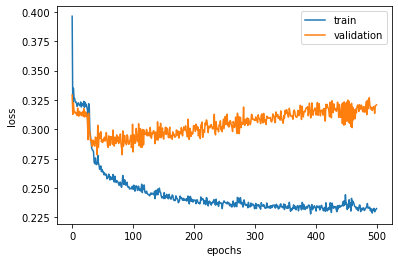

In [105]:
plt.plot(history_LSTM.history['loss'], label='train')
plt.plot(history_LSTM.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

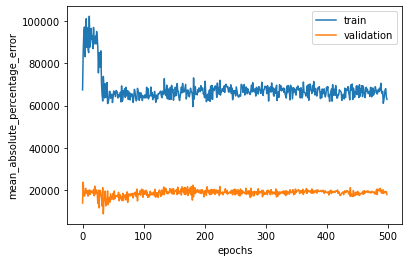

In [106]:
plt.plot(history_LSTM.history['mean_absolute_percentage_error'], label='train')
plt.plot(history_LSTM.history['val_mean_absolute_percentage_error'], label='validation')
plt.xlabel('epochs')
plt.ylabel('mean_absolute_percentage_error')
plt.legend()
plt.show()

In [107]:
sample = 2

y_pred = model_LSTM.predict(
    [x_train[sample].reshape(1, max_x_len, 5)]
    ).reshape(max_x_len, 2)

y_pred.shape, x_train[sample].shape

(None, 77)


((77, 2), (77, 5))

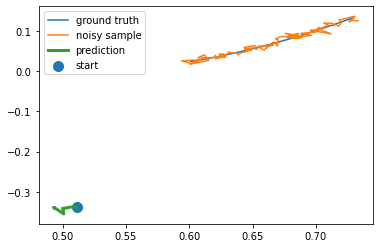

In [108]:
plt.plot(y_train[sample][:, 0], y_train[sample][:, 1], label='ground truth')
plt.plot(x_train[sample][:, 0], x_train[sample][:, 1], label='noisy sample')
plt.plot(y_pred[:, 0], y_pred[:, 1], label='prediction', linewidth=3)
plt.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=100)

plt.legend()
plt.show()

In [110]:
import random
x_rl = [] # sampled noisy GPS, list of lists of tuples, (100, 77, 5, 2)
y_gps_rl = [] # sampled noisy GPS, list of lists of tuples, (100, 77, 5, 2)
# RIGHT LANE
for df in random.sample(rl_seg_gps_noise, 100):
    # x_rl.append(df[['y_norm_noise', 'x_norm_noise', 'theta_norm', 'Vx_norm', 'Vy_norm']].values)
    x_rl.append(df[['y_norm_noise', 'x_norm_noise', 'theta_norm', 'alpha_Xv_norm', 'alpha_Yv_norm']].values)
    y_gps_rl.append(df[['y_norm', 'x_norm']].values)
    # use right lane segments as testing set
x_test = np.asarray(x_rl) # (100, 77, 5, 2)
y_test = np.asarray(y_gps_rl) # (100, 77, 2)

x_test.shape, y_test.shape

((100, 77, 5), (100, 77, 2))

In [111]:
train_mspe = model_LSTM.evaluate(x_train, y_train)
test_mspe = model_LSTM.evaluate(x_test, y_test)

print()
print("Train set [MSE, MAPE] with LSTM Attentional autoencoders = ", train_mspe)
print("Test set [MSE, MAPE] with LSTM Attentional autoencoders = ", test_mspe)

4/4 [==============================] - 0s 35ms/step - loss: 0.4125 - mean_absolute_percentage_error: 24355.2715

Train set [MSE, MAPE] with LSTM Attentional autoencoders =  [0.4251643121242523, 52227.39453125]
Test set [MSE, MAPE] with LSTM Attentional autoencoders =  [0.4124922454357147, 24355.271484375]


In [112]:
y_test_pred = model_LSTM.predict(x_test)
y_test_pred.shape

(None, 77)


(100, 77, 2)

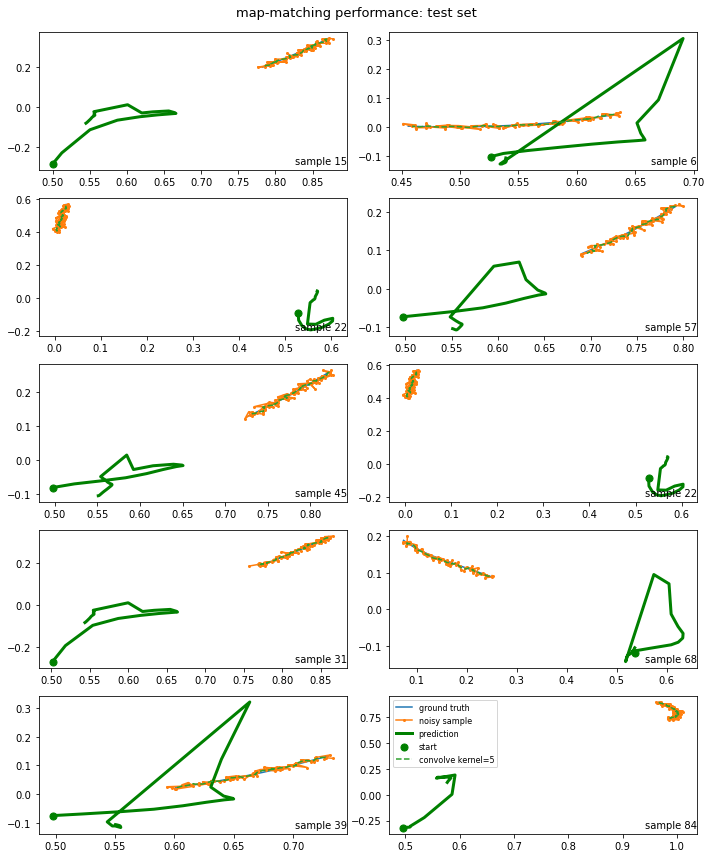

In [113]:

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("map-matching performance: test set", fontsize=13, y=0.99)

np.random.seed(17)
for sample, ax in zip(np.random.randint(0, 100, 10), axs.ravel()):
    y_pred = y_test_pred[sample]
    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    lat_noisy_convolved = np.convolve(x_test[sample][:, 0], kernel, mode='valid')
    lon_noisy_convolved = np.convolve(x_test[sample][:, 1], kernel, mode='valid')

    ax.plot(y_test[sample][:, 0], y_test[sample][:, 1], label='ground truth')
    ax.plot(x_test[sample][:, 0], x_test[sample][:, 1], '-o', label='noisy sample', ms=2)
    ax.plot(y_pred[:, 0], y_pred[:, 1], label='prediction', linewidth=3, c='green')
    ax.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=50, c='green')
    ax.plot(lat_noisy_convolved, lon_noisy_convolved, '--', label='convolve kernel=5')

    ax.set_title(f'sample {sample}', y=0, loc='right', fontdict={'fontsize': 10})

plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

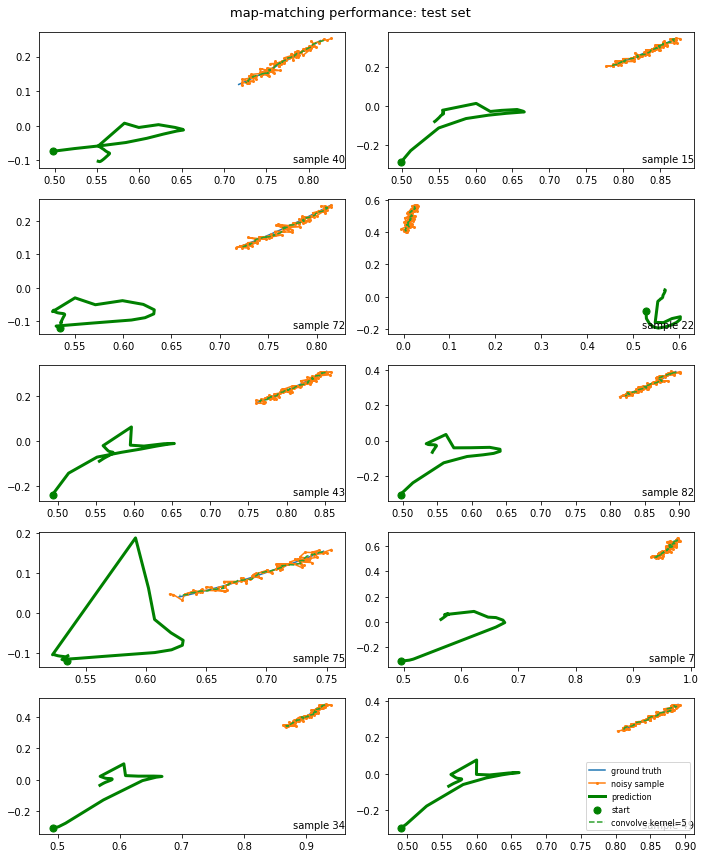

In [114]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("map-matching performance: test set", fontsize=13, y=0.99)

np.random.seed(2)
for sample, ax in zip(np.random.randint(0, 100, 10), axs.ravel()):
    y_pred = y_test_pred[sample]
    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    lat_noisy_convolved = np.convolve(x_test[sample][:, 0], kernel, mode='valid')
    lon_noisy_convolved = np.convolve(x_test[sample][:, 1], kernel, mode='valid')

    ax.plot(y_test[sample][:, 0], y_test[sample][:, 1], label='ground truth')
    ax.plot(x_test[sample][:, 0], x_test[sample][:, 1], '-o', label='noisy sample', ms=2)
    ax.plot(y_pred[:, 0], y_pred[:, 1], label='prediction', linewidth=3, c='green')
    ax.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=50, c='green')
    ax.plot(lat_noisy_convolved, lon_noisy_convolved, '--', label='convolve kernel=5')

    ax.set_title(f'sample {sample}', y=0, loc='right', fontdict={'fontsize': 10})

plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

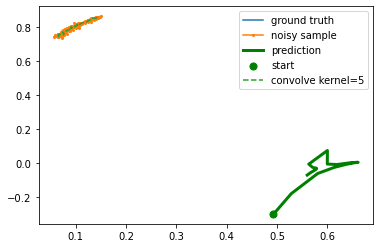

In [115]:
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size
lat_noisy_convolved = np.convolve(x_train[sample][:, 0], kernel, mode='valid')
lon_noisy_convolved = np.convolve(x_train[sample][:, 1], kernel, mode='valid')

plt.plot(y_train[sample][:, 0], y_train[sample][:, 1], label='ground truth')
plt.plot(x_train[sample][:, 0], x_train[sample][:, 1], '-o', label='noisy sample', ms=2)
plt.plot(y_pred[:, 0], y_pred[:, 1], label='prediction', linewidth=3, c='green')
plt.scatter(y_pred[:, 0][0], y_pred[:, 1][0], label='start', s=50, c='green')
plt.plot(lat_noisy_convolved, lon_noisy_convolved, '--', label='convolve kernel=5')

plt.legend()
plt.show()